# Trabalho final de NLP - Victor Henrique Silva Ribeiro
## Introdução
O foco desse trabalho é utilizar o processamento de linguagem natural, e outras técnicas de machine learning, para analisar grandes quantidades de cúrriculos enviados para diferentes vagas de emprego. 

O objetivo é ter uma visão geral sobre a similaridade dos currículos, isso é útil para empresas que recebem muitas aplicações e precisam de uma forma rápida e coerente para analisar-las, já que muitas vezes a leitura completa de todos os currículos é inviável e não muito eficiente. Algumas das possíveis aplicações são:

- Dado um currículo que o recrutador ache adequado para a vaga, ele pode utilizar o modelo para encontrar outros currículos parecidos com esse. 
- O recrutador pode encontrar visualmente currículos de pessoas que possuem multiplas habilidades, formações ou experiências.
- O modelo fornece um método visual para a escolha de cúrriculos para a leitura manual, o recrutador pode escolher um conjunto de currículos distantes entre si (pouco parecidos) para ter uma visão geral sobre os candidatos.

Instalando e importando as bibliotecas necessárias

In [12]:
%pip install scikit-learn
%pip install scipy
%pip install sentence-transformers
%pip install transformers
%pip install datasets
%pip install faiss
%pip install torch
%pip install matplotlib
%pip install pandas

import pandas as pd
from datasets import load_dataset

import torch
from sentence_transformers import SentenceTransformer, models

from sklearn.manifold import MDS
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.image as mpimg

from IPython.display import Image


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Carregando o dataset de currículos disponível no `Hugging Face 🤗`. O dataset é composto por 3 colunas: currículo, área da vaga e email do candidato, no total são 2480 currículos de pessoas que se candidataram para vagas de emprego em diferentes áreas. Mantenho somente 500 exemplos pois o dataset possui currículos para 24 áreas de atuação diferente, oque prejudica a visualização por tornar os dados muito aglomerados.

In [5]:
dataset = load_dataset("talanAI/resumesamples")
dataset = pd.DataFrame(dataset['train'])
dataset = dataset.dropna()
dataset = dataset[:500]

c:\Users\Vitão\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 80.33it/s]
Generating train split: 2483 examples [00:00, 8688.07 examples/s]


A arquitetura escolhida para compor o modelo que fará o processamento de linguagem natual é a arquitetura de `Sentence Transformers`, que são transformers pré-treinados para realizar tarefas de similaridade entre sentenças. Esses transformers são treinados para maximizar a similaridade entre sentenças que são semanticamente similares e minimizar a similaridade entre sentenças que são semanticamente diferentes. A similiaridade entre sentenças é calculada utilizando a distância entre os embeddings das sentenças.

Temos muito pouco dado para realizar o fine-tunning desses transformers. A solução adotada para otimizar os resultados foi selecionar o transformer pré-treinado que melhor agrupava os currículos por área de atuação, já que essa é a principal métrica que temos para avaliar a qualidade das similaridades encontradas. O modelo selecionado foi o `"sentence-transformers/multi-qa-MiniLM-L6-cos-v1"`, que é um modelo pré-treinado criado para pesquisa semântica, ele foi treinado utilizando 215 milhões de pares (pergunta, resposta) de fontes diversas.

In [6]:
model_names = ['multi-qa-mpnet-base-dot-v1', 'all-mpnet-base-v2', 'multi-qa-distilbert-cos-v1', 'multi-qa-MiniLM-L6-cos-v1']
word_embedding_model = models.Transformer(f"sentence-transformers/{model_names[3]}")

# Aplica mean pooling para obter um vetor de sentença de tamanho fixo
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

config.json: 100%|██████████| 612/612 [00:00<?, ?B/s] 
c:\Users\Vitão\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vitão\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:04<00:00, 21

Aqui de fato gero as similaridades para cada par de currículos.

In [7]:
# Codificando os currículos em vetores reais (embeddings)
resume_embeddings = model.encode(dataset['Resume'].tolist(), convert_to_tensor=True)

# Calcula a distância euclidiana entre todos os pares de currículos
euclidean_distances = torch.pdist(resume_embeddings, p=2).cpu()

# Gera uma matriz de distâncias quadrada a partir dos resultados
euclidean_distances = squareform(euclidean_distances.numpy())

A partir da matriz de distância é aplicada uma técnica de redução de dimensionalidade (Multidimensional Scaling) para se obter as coordenadas no plano que melhor representam as distâncias na matriz.

In [8]:
# Gera coordenadas no plano a partir da matriz de distâncias
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(euclidean_distances)
xs, ys = pos[:, 0], pos[:, 1]

c:\Users\Vitão\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Com as coordenadas calculadas aplico um algoritmo de `Clustering` para agrupar os currículos por área de atuação. Como sempre sabemos antecipadamente quantas áreas de atuação estamos analisando, então utilizo o k-means com `k=5` para o exemplo atual.

In [9]:
# Aplica o algoritmo de agrupamento k-means nos pontos definidos em xs e ys
kmeans = KMeans(n_clusters=5, random_state=0).fit(pos)
kmeans_error = kmeans.inertia_
print(kmeans_error)

c:\Users\Vitão\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


383.39898349910806


O *"transformer pré-treinado que melhor agrupa os currículos por área de atuação"* é escolhido através do compromisso entre o erro do k-means (soma dos quadrados residuais) e a separação visual dos dados. Existem modelos que apesar de terem um erro baixo, separam os dados visualmente de forma não consistente. Essa separação visual é importante pois faz sentido pensar que a área de atuação para o qual um currículo foi enviado possui tanta (ou mais) importância quanto a similaridade semântica.

Abaixo defino o procedimento para a montagem do scatterplot que sintetiza todas as informações importantes para a análise visual do resultado.

In [ ]:
# Plota os centróides e as linhas delimitadoras dos clusters
clusters_centers = kmeans.cluster_centers_
plt.scatter(clusters_centers[:, 0], clusters_centers[:, 1], s=100, c='black', marker='x')
vor = Voronoi(clusters_centers)
fig = voronoi_plot_2d(vor, plt.gca())

# Mapeia as áreas de atuação de cada currículo para cores
categories = dataset['Category'].tolist()
category_dict = {category: i for i, category in enumerate(set(categories))}
categories = [category_dict[cat] for cat in categories]
colormap = plt.cm.get_cmap('tab20b', len(set(categories)))

# Plota o gráfico de dispersão (scatterplot) com cores baseadas nas áreas de atuação
scatter = plt.scatter(xs, ys, c=categories, cmap=colormap)

# Cria uma legenda para as cores
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=
                      colormap(category_dict[category]/len(set(categories))), markersize=10) for category in category_dict]
plt.legend(handles, category_dict.keys(), title="Categories", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.show()

Ao análisar todos os agrupamentos lado a lado podemos observar que o modelo que minimiza o erro do k-means não é o que melhor separa visualmente as áreas de atuação, por isso o modelo que possui o erro de 383,39 é preferível.

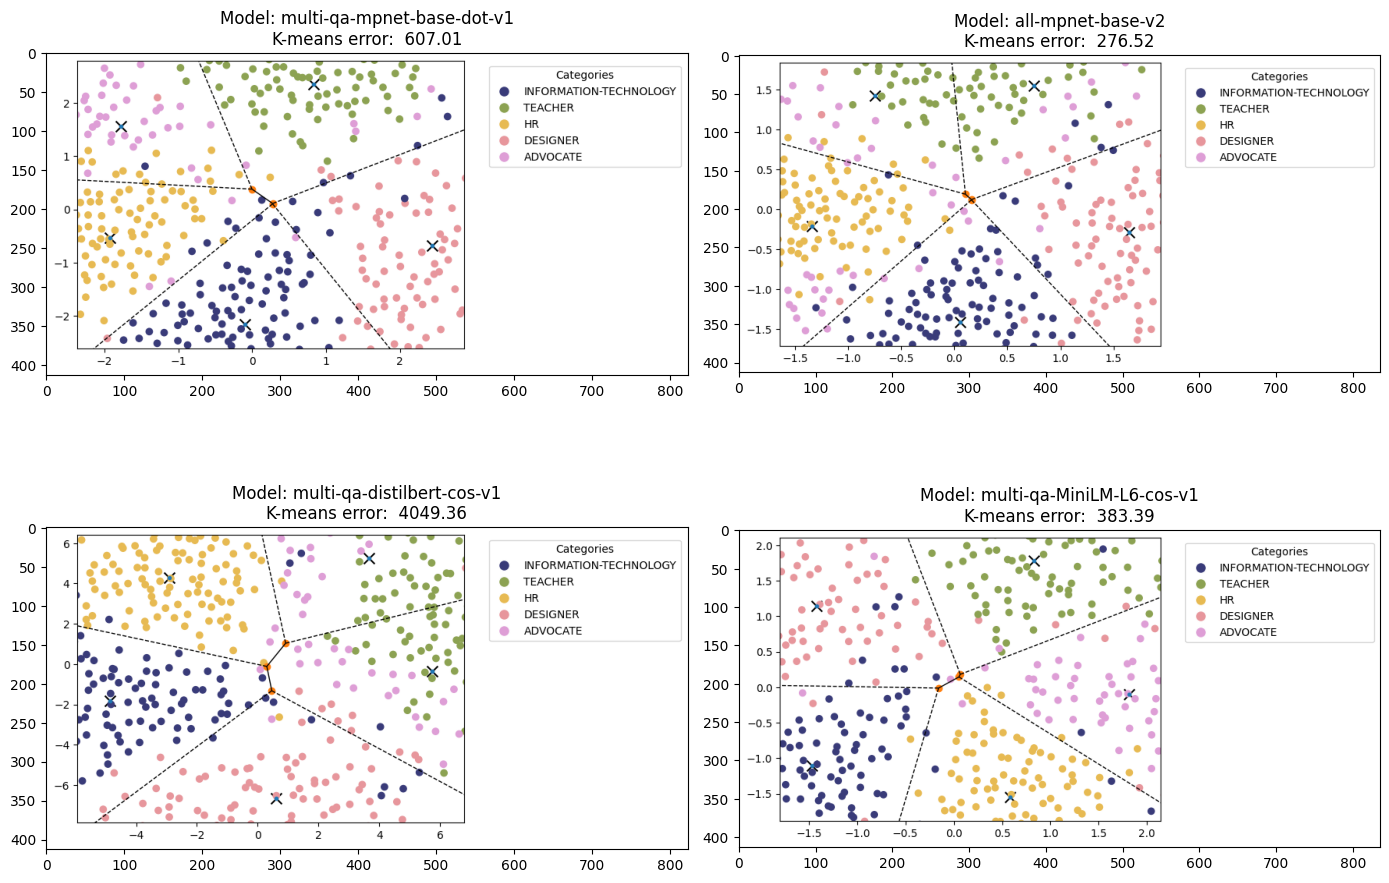

In [14]:
# Mostra os resultados de cada modelo pré-treinado
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, ax in enumerate(axs.flat):
    with open(f'{model_names[i]}/error.txt', 'r') as f:
        current_kmeans_error = f"{float(f.read()): .2f}"

    img = mpimg.imread(f'{model_names[i]}/plot.png')
    ax.imshow(img)
    ax.set_title(f'Model: {model_names[i]}\nK-means error: {current_kmeans_error}')

plt.tight_layout()
plt.show()

Finalmente, com esse scatterplot podemos para cada currículo encontrar os mais (ou menos) similares a ele, além de poder encontrar currículos de pessoas que possuem múltiplas formações.

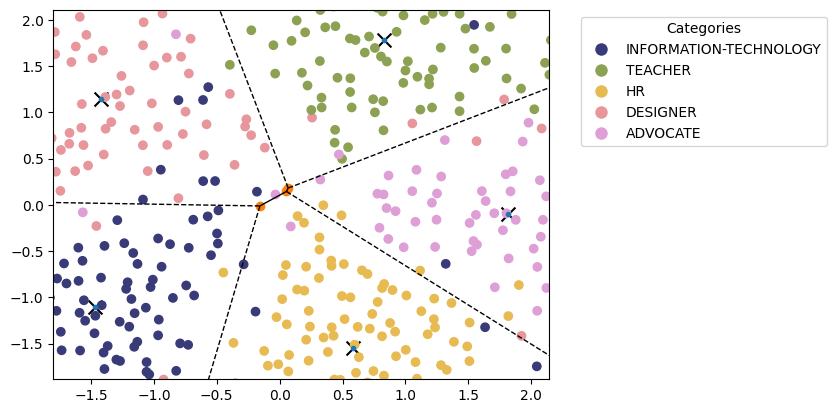

In [13]:
Image(filename='multi-qa-MiniLM-L6-cos-v1/plot.png')